#Исследование обьявлений о продаже квартир

>В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

>По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

### Открываем файл с данными и изучаем общую информацию. 

In [8]:
import pandas as pd
df = pd.read_csv('/content/2_real_estate_data.csv', sep = '\t')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Заметил следующее:
1. first_day_exposition - object - должен быть тип datetime
2. ceiling_height - нулевые значения
3. floors_total - должен быть тип int, т.к. количество этажей - целое значение + нулевые значения
4. is_apartment - должен быть тип bool + нулевые значения
5. living_area - нулевые значения
6. kitchen_area - нулевые значения
7. balcony - нулевые значения
8. locality_name  - нулевые значения
9. airports_nearest - нулевые значения
10. cityCenters_nearest - нулевые значения
11. parks_around3000 - тип должен быть int + нулевые значения
12. parks_nearest  - нулевые значения
13. ponds_around3000 - тип должен быть int + нулевые значения
14. ponds_nearest - нулевые значения
15. days_exposition - тип должен быть int + нулевые значения 

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')


count    21796.000000
mean        34.457852
std         22.030445
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

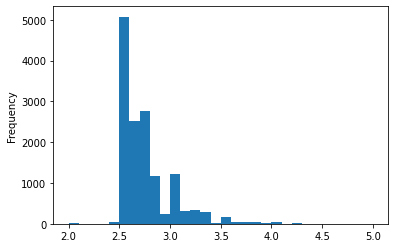

In [18]:
print(df.columns)
# оставляем без изменения столбцы
df['total_images'].value_counts()
df['ceiling_height'].value_counts()
df['floor'].value_counts()
df['is_apartment'].value_counts()
df['total_area'].value_counts()
df['rooms'].value_counts()
df['airports_nearest'].value_counts()
df['cityCenters_nearest'].value_counts()
df['parks_around3000'].value_counts()
df['parks_nearest'].value_counts()
df['ponds_around3000'].value_counts()
df['balcony'].value_counts()
df['locality_name'].value_counts()

# заменим нулевые значения + изменим тип данных
df['days_exposition'] = df['days_exposition'].fillna(0).astype('int')

# переведем столбец с датой в формат даты без времени, т.к. время не указано
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'] , format='%Y-%m-%d')

# заменим пропуски в balcony на 0 и изменим тип данных на int
df['balcony'] = df['balcony'].fillna(0).astype('int')

# посмотрим параметр ceiling_height, видим что есть необоснованно большие значения но пока оставим их как есть,
# медиана от среднего отличается не сильно из-за этих выбросов во всей выборке
df['ceiling_height'].sort_values().plot(y = 'ceiling_height', kind = 'hist', bins = 30, range=(2,5))
df['ceiling_height'].value_counts()
df['ceiling_height'].describe()
df[df['ceiling_height'] > 4].sort_values('ceiling_height').tail(20)

# столбец апартаменты видимо появился не вместе с началом ведения записей, все пропущенные значения заменим на False, 
# апартаменты появились относительно недавно
df['is_apartment'] = df['is_apartment'].fillna(False)

# изменим цену на тип int для удобства просмотра
df['last_price'] = df['last_price'].astype('int')

# посмотрим данные с пропущенными значениями в floors_total- ничего общего между ними нет, оставим как есть
df[df['floors_total'].isna()]

# living_area слишком много знаков после запятой и есть пропущенные значения, 
# можно посчитать средний процент жилой площади от всей площади по всей выборке
# и высчитать для строк с пропусками жилую площадь как вариант но мы не будем тратить на это время
df['living_area'].value_counts()
df['living_area'].describe()

### Посчитайте и добавьте в таблицу

1. цену квадратного метра;
2. день недели, месяц и год публикации объявления;
3. этаж квартиры; варианты — первый, последний, другой;
4. соотношение жилой и общей площади, а также отношение площади кухни к общей.

In [71]:
# посчитаем цену квадратного метра
df['price_per_square_meter'] = df['last_price'] / df['total_area']
df['price_per_square_meter'] = df['price_per_square_meter'].astype('int')

# создаю столбец дня недели
df['weekday_exposition'] = df['first_day_exposition'].dt.weekday

# создаю столбец месяца
df['month_exposition'] = df['first_day_exposition'].dt.month

# создаю столбец года
df['year_exposition'] = df['first_day_exposition'].dt.year

# напишем функцию категоризации по этажам, используя метод apply применимо к каждой строке датафрейма через axis = 1
def floor_category(row):
    floors_total = row['floors_total']
    floor = row['floor']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    elif 1 < floor < floors_total:
        return 'другой'
    
# категоризуем этажи с помощью функции  
df['floor_category'] = df.apply(floor_category, axis = 1)

# добавим столбец соотношения жилой площади к общей
df['useful_area_ratio'] = df['living_area'] / df['total_area']

# добавим столбец отношения площади кухни к общей
df['kitchen_area_ratio'] = df['kitchen_area'] / df['total_area']

### Проведите исследовательский анализ данных и выполните инструкции:
#### 1. Изучение следующих параметров: площадь, цена, число комнат, высота потолков. Гистограммы для каждого параметра.

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

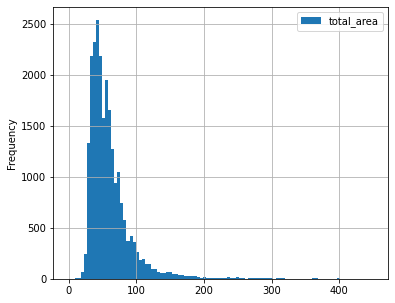

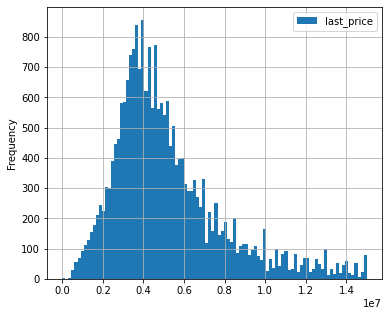

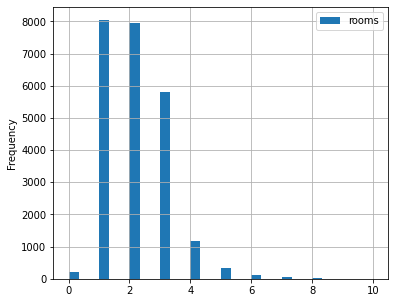

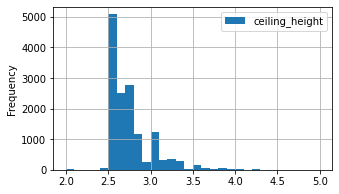

In [43]:
# Изучение площади
df.plot(y= 'total_area', kind='hist', bins = 100, grid = True, figsize = (6,5),  range = (0,450))
df['total_area'].describe()
# распределение данных нормальное, есть выбросы но они не сильно влияют на данные 

# Изучение цены
df.plot( y= 'last_price', kind='hist', bins = 100, grid = True, figsize = (6,5),  range = (0,15000000))
df['last_price'].describe()
# с данными все впорядке но значения выводятся в экспоненциальной записи чисел

# Изучение количества комнат
df.plot( y= 'rooms', kind='hist', bins = 30, grid = True, figsize = (6,5), range = (0, 10))
df['rooms'].describe()
# с данными все впорядке

# Изучение высоты потолков
df.plot(y = 'ceiling_height', kind = 'hist', bins = 30, range = (2,5), grid=True, figsize = (5,3))
df['ceiling_height'].describe()
# с данными все впорядк

**Вывод:** 
1. Общая площадь в нашей выборке колеблется от 12 до 900 м2, среднее значение 60, а медиана 52 м2. Распределение данных по Гауссу.

2. Цены на недвижимость имеют среднее значение в 6,5 млн руб., медиана 4,6 млн руб. Распределение данных по Гауссу.

3. Количество комнат колеблется от 1 до 19. Больше всего однокомнатных квартир.

4. Высота потолков в среднем составляет 2,77 м, медиана 2,65 м.

Во всех данных есть неадекватные значения: 0 комнат, высоты потолков в 1 или 100 метров, а также цена квартиры в 12190 рублей. О данных неадекватных значениях мы спросим у сотрудников, предоставивших нам выборку данных, для общего изучения данных, мы не станем убирать эти выбивающиеся значения.

#### 2. Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?

Прежде чем начать выполнять это задание сделаем предположение, что дата снятия объявления может не считаться датой продажи, причем в непонятном для нас количестве случаев...

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

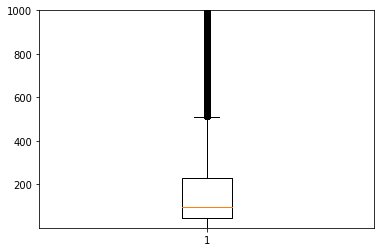

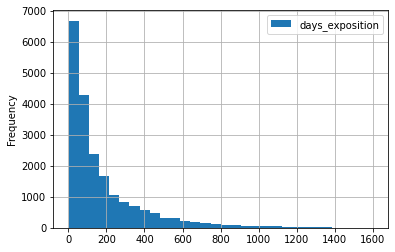

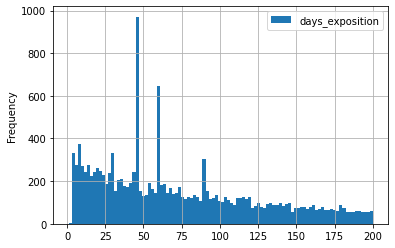

In [56]:
import matplotlib.pyplot as plt
# диаграмма размаха
plt.boxplot(df[df['days_exposition'] != 0]['days_exposition'])
plt.ylim(1,1000)

df.plot(y = 'days_exposition', kind = 'hist', bins = 30, grid = True, range = (1,1600))
df.plot(y = 'days_exposition', kind = 'hist', bins = 100, grid = True, range = (1,200))

# среднее значение, медиана и межквартильный размах
df[df['days_exposition']!=0]['days_exposition'].describe()
#df[df['days_exposition']!=0]['days_exposition'].value_counts()


**Вывод:** судя по гистограмме - мы имеем распределение Пуассона. Среднее значение - 180 дней, а медиана - 95 дней.
Сделав гистограмму со значениями от 0 до 200 с кол-вом корзин 100, обнаружили выбивающиеся значения и методом value_counts убедились в этом - у нас аномалии на 45, 60, 7, 30, 90 днях - это наиболее популярное количество дней до снятия объявления.

Загуглил правила размещения объявлений в Яндекс Недвижимость, оказалось что именно после этих сроков объявление считается неактуальным и снимается автоматически.
https://yandex.ru/support/realty/owner/home/add-ads-housing.html
Наверное, нам нужно убрать эти значения из выборки, но нужно подумать есть ли еще критерии для снятия таких объявлений, ведь часть из таких квартир могла и правда продаться в этот срок.


In [58]:
df[df['days_exposition']==45]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square_meter
78,9,4350000,37.0,2018-02-22,1,NaN,19.0,18.0,6,False,False,False,10.7,0,Санкт-Петербург,34324.0,14192.0,0.0,NaN,0.0,NaN,45,117567
89,9,2500000,63.0,2018-10-25,3,2.50,5.0,43.0,4,False,False,False,9.0,0,посёлок городского типа Сиверский,NaN,NaN,NaN,NaN,NaN,NaN,45,39682
110,6,3850000,72.3,2017-09-29,2,NaN,3.0,27.4,2,False,False,False,23.6,0,деревня Пикколово,NaN,NaN,NaN,NaN,NaN,NaN,45,53250
153,12,4350000,55.0,2017-05-21,2,2.57,9.0,31.2,2,False,False,False,8.3,0,Петергоф,45958.0,34425.0,1.0,589.0,0.0,NaN,45,79090
158,15,3100000,47.3,2017-11-07,2,NaN,5.0,27.5,2,False,False,False,8.5,0,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,45,65539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23601,10,2900000,43.4,2018-01-11,2,NaN,5.0,NaN,1,False,False,False,NaN,0,Санкт-Петербург,22001.0,14193.0,1.0,202.0,2.0,397.0,45,66820
23613,4,3950000,52.0,2018-03-04,3,NaN,5.0,NaN,2,False,False,False,NaN,0,посёлок Парголово,55549.0,21223.0,0.0,NaN,0.0,NaN,45,75961
23670,9,2450000,45.6,2018-02-08,1,2.80,9.0,NaN,2,False,False,False,NaN,0,поселок городского типа Синявино,NaN,NaN,NaN,NaN,NaN,NaN,45,53728
23679,0,2500000,35.0,2017-12-08,1,NaN,9.0,NaN,4,False,False,False,NaN,0,Сосновый Бор,NaN,NaN,NaN,NaN,NaN,NaN,45,71428


**Вывод:** никаких общих особенностей в обьявлениях, снятых через 45 дней не выявлено, потому будем убирать эти данные из наших расчетов, как и данные с 60, 90, 30 и 7 дней в столбце days_exposition, так как это аномалии.

До того, как мы очистим наши данные от аномалий, нам нужно дать ответ на вопрос, какое количество дней считать нормальным, а какое выбросом на текущий момент до очистки данных.
Исходя из метода describe, межквартильный размах - от 45 до 232 дней, исходя же из метода boxplot - диаграмма размаха у нас от минимального значения до примерно 500 дней. Значит необоснованно быстрых значений у нас нет, а необоснованно долгие - от 500 дней и выше. Значит нормальные значения у нас лежат от 1 до 500.

На текущий момент мы уже знаем, что эти данные неправильные, но они нам нужны, чтобы сравнить с данными, очищенными от аномалий далее.

Считаю важным уточнить у сотрудников насчет выбивающихся значений по датам снятия объявлений, чтобы убедиться в том, какие данные необходимо исключить из выборки.

#### 3. Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили.

count    18454.000000
mean       195.803349
std        226.760010
min          1.000000
25%         44.000000
50%        114.000000
75%        259.000000
max       1580.000000
Name: days_exposition, dtype: float64

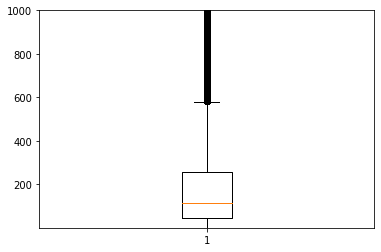

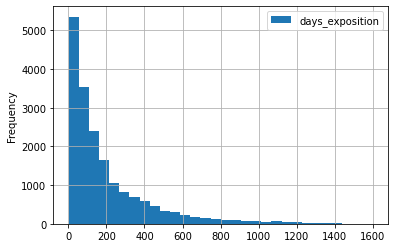

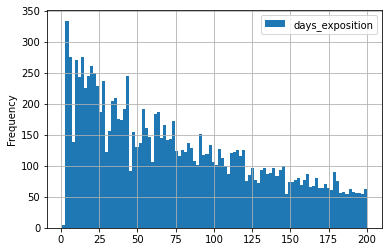

In [59]:
# отфильтруем данные от аномалий и запишем их в новый датафрейм good_data
good_df = df.query('days_exposition != 45 and days_exposition != 30 and days_exposition != 60 and days_exposition != 90 and days_exposition != 7 and days_exposition != 0')

# диаграмма размаха
plt.boxplot(good_df['days_exposition'])
plt.ylim(1,1000)

# гистограммы
good_df.plot(y = 'days_exposition', kind = 'hist', bins = 30, grid = True, range = (1,1600))
good_df.plot(y = 'days_exposition', kind = 'hist', bins = 100, grid = True, range = (1,200))

# среднее значение, медиана и межквартильный размах
#good_df['days_exposition'].value_counts()
good_df['days_exposition'].describe()


**Вывод**: ожидаемо, в очищенных данных с аномалиями в значениях меньших медианы получаем бОльшие значения медианы и среднего значения - 114 и 195 соответственно, вместо 95 и 180. Аналогично, теперь нормальные значения располагаются от 1 до 600 дней вместо от 1 до 500 дней.

#### 4. Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена квадратного метра от общей площади квартиры, числа комнат, этажа (первого или последнего), удалённости от центра. Также изучите зависимость от даты размещения: дня недели, месяца и года.

**Изучим зависимость цены квадратного метра от общей площади квартиры.**

,price_per_square_meter,total_area
price_per_square_meter,1.00000,0.30196
total_area,0.30196,1.00000


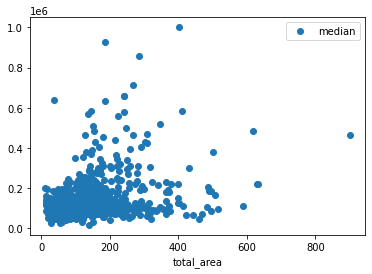

In [62]:
pivot_table_total_area = df.pivot_table(index = 'total_area', values = 'price_per_square_meter', aggfunc = ['mean', 'count', 'median'])
pivot_table_total_area.columns = ['mean', 'count', 'median']
pivot_table_total_area.plot(y = 'median', style = 'o')

df[['price_per_square_meter', 'total_area']].corr()

**Вывод:** видим, что зависимость очень слабая - согласно корреляции Пирсона - 0.3! То есть, чем больше площадь тем немного выше стоимость!

**Изучим зависимость цены квадратного метра от числа комнат.**


,rooms,price_per_square_meter
rooms,1.000000,0.055419
price_per_square_meter,0.055419,1.000000


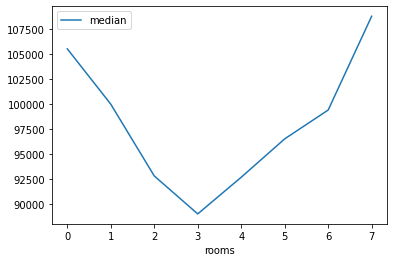

In [64]:
pivot_table_rooms = df.pivot_table(index = 'rooms', values = 'price_per_square_meter', aggfunc = ['mean', 'count', 'median'])
pivot_table_rooms.columns = ['mean', 'count', 'median']
pivot_table_rooms.query('count > 50').plot(y = 'median')

df[['rooms', 'price_per_square_meter']].corr()

**Вывод:** чем ближе количество комнат к 3 тем ниже стоимость квадратного метра.

**Изучим зависимость цены квадратного метра от этажа (первого или последнего).**

,mean,count,median
floor_category,,,
первый,81983.111759,2917,81223
последний,93410.267686,3336,87777


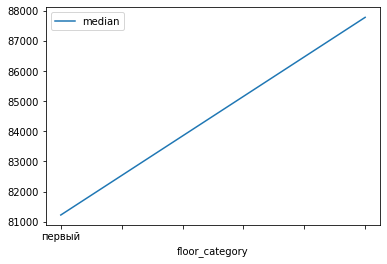

In [90]:
pivot_table_floor_category = df.query('floor_category != "другой"').pivot_table(index = 'floor_category', values = 'price_per_square_meter', aggfunc = ['mean', 'count', 'median'])
pivot_table_floor_category.columns = ['mean', 'count', 'median']
pivot_table_floor_category.plot(y = 'median')
pivot_table_floor_category

**Вывод:** из графика ничего не понятно! Согласно медиане - как правило квартиры на первом этаже дешевле квартир на последнем этаже - в среднем на 10%!

**Изучим зависимость цены квадратного метра от удалённости от центра.**

,cityCenters_nearest,price_per_square_meter
cityCenters_nearest,1.000000,-0.317951
price_per_square_meter,-0.317951,1.000000


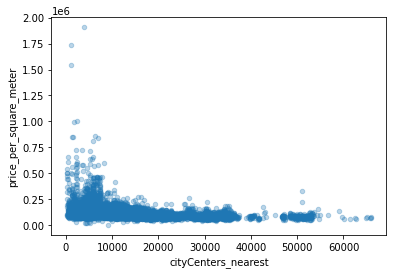

In [66]:
df.plot(kind = 'scatter', y = 'price_per_square_meter', x = 'cityCenters_nearest', alpha = 0.3)

df[['cityCenters_nearest', 'price_per_square_meter']].corr()

**Вывод**: Чем ближе к центру, тем цена квадратного метра выше.

**Изучим зависимость цены квадратного метра от даты размещения: дня недели.**

,mean,count,median
weekday_exposition,,,
1,99734.089410,4183,95634.0
2,99616.731002,3974,95473.0
3,100162.466356,4295,95143.0
0,99437.994463,3612,94688.0
4,99011.697000,4000,94616.0
6,97707.917010,1699,94501.0
5,99017.722107,1936,93545.5


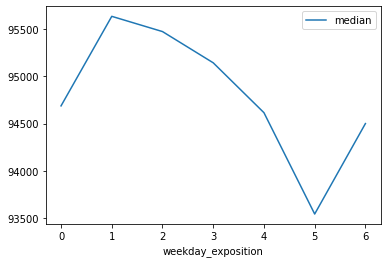

In [72]:
pivot_table_weekday_exposition = df.pivot_table(index = 'weekday_exposition', values = 'price_per_square_meter', aggfunc = ['mean', 'count', 'median'])
pivot_table_weekday_exposition.columns = ['mean', 'count', 'median']
pivot_table_weekday_exposition.plot(y = 'median')

pivot_table_weekday_exposition.sort_values('median', ascending = False)

**Вывод:** видим, что чем ближе ко вторнику выставлены объявления тем в среднем выше стоимость, но незначительно! По субботам стоимость самая низкая!

Полагаю, что стоимость выставленной на продажу недвижимости зависит от общей активности людей, так как именно в рабочие дни мы видим более высокие цены.

**Изучим зависимость цены квадратного метра от даты размещения: месяца.**


,mean,count,median
month_exposition,,,
4,101948.567045,2379,96451
8,100110.094037,1744,96026
9,100463.814740,1981,95607
11,99230.427246,2371,95588
3,98972.768844,2587,95238
1,99862.139333,1500,95222
2,98768.292045,2640,95000
7,99625.190560,1695,95000
12,99574.280926,1641,94262


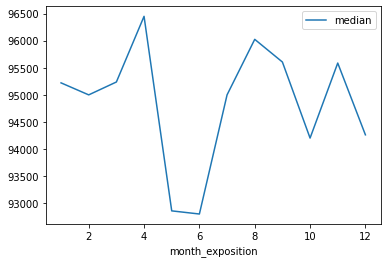

In [74]:
pivot_table_month_exposition = df.pivot_table(index = 'month_exposition', values = 'price_per_square_meter', aggfunc = ['mean', 'count', 'median'])
pivot_table_month_exposition.columns = ['mean', 'count', 'median']
pivot_table_month_exposition.plot(y = 'median')

pivot_table_month_exposition.sort_values('median', ascending = False)

**Вывод:** самая высокая стоимость метра в апреле и августе! Самая низкая стоимость в мае и июне!
На рынке недвижимости, как и во многих других сферах присутствует сезонность - в начале лета мы видим наименьшее предложение как по количеству, так и по стоимости недвижимости. Высокий сезон - весна и осень, низкий сезон лето.

**Изучим зависимость цены квадратного метра от даты размещения: года.**


,mean,count,median
year_exposition,,,
2014,124830.000000,137,107000.0
2019,107123.332060,2879,103305.0
2018,97773.107290,8519,95689.0
2015,104613.756507,1191,93414.0
2017,97621.434188,8190,92564.5
2016,98321.900467,2783,91743.0


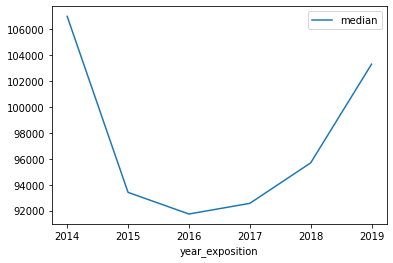

In [75]:
pivot_table_year_exposition = df.pivot_table(index = 'year_exposition', values = 'price_per_square_meter', aggfunc = ['mean', 'count', 'median'])
pivot_table_year_exposition.columns = ['mean', 'count', 'median']
pivot_table_year_exposition.plot(y = 'median')

pivot_table_year_exposition.sort_values('median', ascending = False)

**Вывод:** видим, что с 2014 до 2016 года цена падала, но далее начала увеличиваться! В СРЕДНЕМ! Мы не рассматриваем сегментацию рынка и по факту стоимость аналогичных квартир могла себя вести абсолютно иначе от года к году!
В выводе присутствует реальный пример.

#### 5. Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце 'locality_name'.

In [78]:
locality_pivot_table = df.pivot_table(index = 'locality_name', values = 'price_per_square_meter', aggfunc=['count', 'mean'])
locality_pivot_table.columns = ['count', 'mean']
locality_pivot_table = locality_pivot_table.sort_values('count', ascending = False).head(10)
locality_pivot_table
#самая высокая стоимость
locality_pivot_table[locality_pivot_table['mean']==locality_pivot_table['mean'].max()]
#самая низкая стоимость
#locality_pivot_table[locality_pivot_table['mean']==locality_pivot_table['mean'].min()]

,count,mean
locality_name,,
Санкт-Петербург,15721,114848.565231


**Вывод:** самая высокая стоимость жилья из 10 населённых пунктов с самым большим количеством объявлений в Санкт-Петербурге, тогда как самая низкая стоимость в Выборге.

#### 6. Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге ('locality_name'). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона.

,price_per_square_meter
cityCenters_nearest_km,
0,187323.674419
1,166603.312500
2,146662.420195
3,129415.891635
4,137475.039691
5,146978.789337
6,152277.455319
7,141399.287469
8,120580.929851


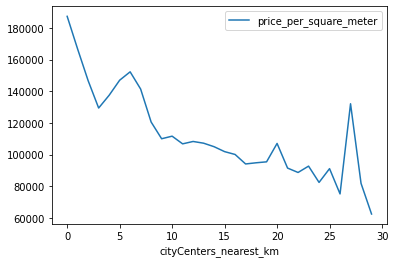

In [79]:
df['cityCenters_nearest_km'] = df['cityCenters_nearest']/1000
df['cityCenters_nearest_km'] = df['cityCenters_nearest_km'].fillna(999999)
df['cityCenters_nearest_km'] = df['cityCenters_nearest_km'].astype('int')
pivot_table_km = df.query('locality_name == "Санкт-Петербург" and cityCenters_nearest_km !=999999').pivot_table(index = 'cityCenters_nearest_km', values = 'price_per_square_meter', aggfunc = 'mean')
pivot_table_km.plot()
pivot_table_km

**Вывод:** судя по графику центром считать будем радиус в 2 километра!

#### 7. Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?

In [91]:
#выделим квартиры в центре, беря за радиус 2 км
center_spb_df = df.query('cityCenters_nearest_km <= 2 and locality_name == "Санкт-Петербург"')

**Зависимость стоимости квадратного метра от количества комнат.**

-0.049720723890895394

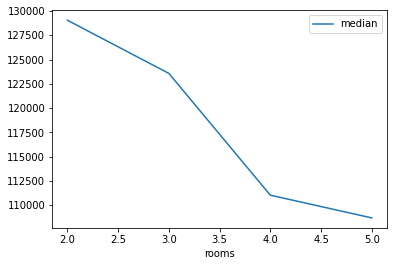

In [92]:
center_spb_rooms = center_spb_df.pivot_table(index = 'rooms', values = 'price_per_square_meter', aggfunc = ['mean', 'count', 'median'])
center_spb_rooms.columns = ['mean', 'count', 'median']
center_spb_rooms.query('count > 50').plot(y = 'median')

center_spb_rooms.query('count > 50').sort_values('median', ascending = False)

center_spb_df['rooms'].corr(center_spb_df['price_per_square_meter'])

**Вывод**: в центре СПБ чем меньше комнат тем дороже стоимость метра квадратного, в отличие от всей выборки, где стоимость уменьшается в зависимости от близости кол-ва комнат к 3! Так мы считаем, исходя из поведения медианной стоимости, в зависимости от количества комнат. Хотя корреляция маленькая, правильнее смотреть именно на график.

**Зависимость стоимости квадратного метра от удаленности от центра.**

-0.16185788050048733

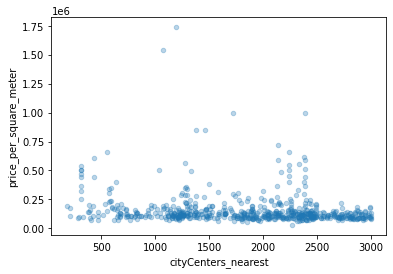

In [93]:
center_spb_df.plot(kind = 'scatter', y = 'price_per_square_meter', x = 'cityCenters_nearest', alpha = 0.3)

center_spb_df['cityCenters_nearest'].corr(center_spb_df['price_per_square_meter'])

**Вывод:** ожидаемо, четкой зависимости нет, так как у нас уже сделана выборка 

**Зависимость стоимости квадратного метра от дня недели размещения объявления.**

,mean,count,median
weekday_exposition,,,
0,167291.467391,92,134285.5
5,148010.888889,45,125000.0
4,146387.245902,122,123656.0
3,170095.666667,141,116784.0
1,173952.566667,90,116055.0
2,149614.817308,104,115524.5
6,154109.846154,39,110843.0


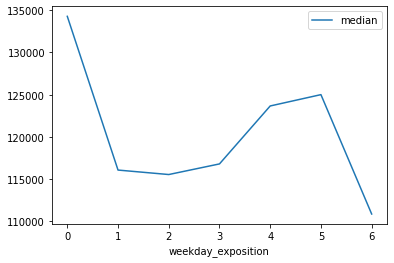

In [94]:
center_spb_weekday_exposition = center_spb_df.pivot_table(index = 'weekday_exposition', values = 'price_per_square_meter', aggfunc = ['mean', 'count', 'median'])
center_spb_weekday_exposition.columns = ['mean', 'count', 'median']
center_spb_weekday_exposition.plot(y = 'median')

center_spb_weekday_exposition.sort_values('median', ascending = False)

**Вывод**: ситуация отличается от всей выборки, минимальные средние цены в четверг и воскресенье, самые высокие - в понедельник и субботу!

**Зависимость стоимости квадратного метра от месяца размещения объявления.**

,mean,count,median
month_exposition,,,
4,205662.936508,63,131034.0
10,162445.152174,46,130028.5
1,155503.333333,48,125000.0
12,172826.442308,52,123952.5
3,164486.859375,64,121168.0
9,147728.392857,56,119262.5
6,144373.619048,42,118852.0
11,149633.232143,56,118724.5
2,151046.893333,75,118556.0


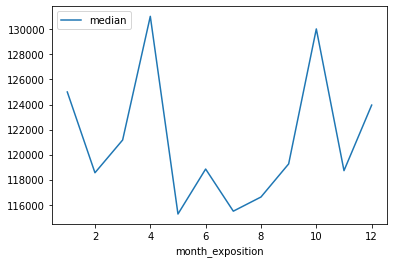

In [95]:
center_spb_month_exposition = center_spb_df.pivot_table(index = 'month_exposition', values = 'price_per_square_meter', aggfunc = ['mean', 'count', 'median'])
center_spb_month_exposition.columns = ['mean', 'count', 'median']
center_spb_month_exposition.plot(y = 'median')

center_spb_month_exposition.sort_values('median', ascending = False)

**Вывод**: ситуация похожая с общей выборкой - самая высокая стоимость метра в апреле и октябре! Самая низкая стоимость в мае и июле!

**Зависимость стоимости квадратного метра от года размещения объявления.**


,mean,count,median
year_exposition,,,
2019,206382.594203,69,134328.0
2018,154184.394118,170,124483.0
2017,153007.160870,230,119765.5
2016,143649.651685,89,114228.0
2015,157765.366197,71,108695.0


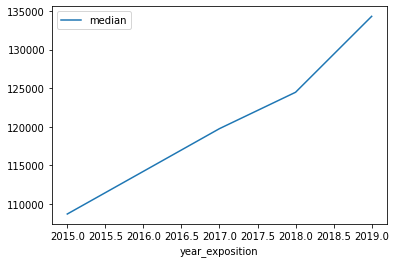

In [96]:
center_spb_year_exposition = center_spb_df.pivot_table(index = 'year_exposition', values = 'price_per_square_meter', aggfunc = ['mean', 'count', 'median'])
center_spb_year_exposition.columns = ['mean', 'count', 'median']
center_spb_year_exposition.query('count > 50').plot(y = 'median')

center_spb_year_exposition.query('count > 50').sort_values('median', ascending = False)

**Вывод:** в отличие от всей выборки - цены в центре СПБ в 2016-2017 годах не падали, а планомерно расли!

### Общий вывод

Мы обработали полученный архив данных - обработали пропущенные значения там, где это необходимо, заменили типы данных на необходимые для удобной работы.
Посчитали и добавили в таблицу цену квадратного метра жилья, вывели из даты дни недели, месяцы и года размещения объявлений, добавили категории по этажам квартир. Изучили следующие параметры на наличие выбивающихся значений - площадь, цена, число комнат, высота потолков. Были определены аномалии в данных параметрах. Изучая время продажи квартир мы выявили, что большое количество объявлений было автоматически снято с Яндекс Недвижимость и дату из снятия нельзя считать датой продажи квартиры, поэтому, изучая средние сроки продажи квартир - данные значения не учитывались.  Мы выявили при помощи диаграммы размаха, что нормальные значения продажи квартир варьируются от 1 до 600 дней.
Мы выявили, что на стоимость квадратного метра квартиры больше всего влияют количество комнат, этаж квартиры, близость к центру. Незначительно на стоимость квадратного метра влияют день, месяц, год размещения и общая площадь. Нужно учитывать, что в 2016-2017 годах стоимость квартир в среднем по рынку была ниже на 10-20 %, тогда как в центре Санкт-Петербурга данной зависимости от года не обнаружено.  В данном случае имело место постоянное удорожание стоимости, начиная с 2015 года по текущий момент. Судя, по резкости изменения цен в зависимости от удаления от центра СПБ, мы выявили центр города в радиусе 2 километров.

Также важно учитывать, что, рассматривая среднюю стоимость квартир в 2014-2019 годах, мы не делали сегментацию рынка, а лишь смотрели средние показатели по рынку в целом. Т.е. возможно, что цены на аналогичные квартиры в разных годах вели себя абсолютно по-разному. Т.е. например в то время, когда средняя стоимость метра по рынку в 2016-2017 годах была наиболее низкой, какие-то аналогичные прошлым годам квартиры могли и не падать в цене, а наоборот дорожать! Именно об этом нам и говорят данные, полученные при изучении единственного сегмента квартир - находящихся в радиусе 2 км в центре СПБ. 